In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import os
import pickle
from copy import deepcopy

In [3]:
PATH = "../../data_processed/resale_flat_prices"
SEED = 42

df = pd.read_csv(os.path.join(PATH, "engineered_data.csv"))


In [4]:
from sklearn.impute import SimpleImputer

df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), 1, 0)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)

df = pd.get_dummies(df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)

print(df.shape, '\n', df.columns)
display(df.head(3))

(865827, 58) 
 Index(['floor', 'age', 'relative_tenure', 'floor_area', 'nearest_atm',
       'nearest_libraries', 'nearest_hawkers', 'nearest_stores',
       'nearest_post_offices', 'nearest_bus_stops', 'nearest_pharmacies',
       'nearest_primary_schools', 'nearest_parks', 'nearest_trains',
       'sale_month', 'cpi', 'cpi_psm', 'avg_sora', 'is_imputted_sora',
       'flat_type_3_ROOM', 'flat_type_4_ROOM', 'flat_type_5_ROOM',
       'flat_type_EXECUTIVE', 'flat_type_OTHER', 'flat_model_APARTMENT',
       'flat_model_IMPROVED', 'flat_model_MAISONETTE', 'flat_model_MODEL_A',
       'flat_model_MODEL_A2', 'flat_model_NEW_GENERATION', 'flat_model_OTHER',
       'flat_model_PREMIUM_APARTMENT', 'flat_model_SIMPLIFIED',
       'flat_model_STANDARD', 'town_ANG_MO_KIO', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT_BATOK', 'town_BUKIT_MERAH', 'town_BUKIT_PANJANG',
       'town_CHOA_CHU_KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG_EAST', 'town_JURONG_WEST', 'to

,floor,age,relative_tenure,floor_area,nearest_atm,nearest_libraries,nearest_hawkers,nearest_stores,nearest_post_offices,nearest_bus_stops,...,town_PASIR_RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA_PAYOH,town_WOODLANDS,town_YISHUN
0,5.0,16,0.899953,70.0,0.521140,0.751719,0.576328,0.521140,0.798752,0.195397,...,0,0,0,0,0,0,0,0,0,0
1,5.0,15,0.902280,120.0,0.391706,0.930882,0.290215,0.368291,3.042559,0.090376,...,0,0,0,0,0,0,0,0,0,0
2,5.0,15,0.902280,63.0,0.165177,1.399324,0.165177,0.047929,1.148847,0.446105,...,0,0,0,0,0,0,0,0,0,0


In [5]:
lookback_years = 4
latest_month = df.sale_month.max()
test_months = list(range(latest_month - lookback_years * 12, latest_month + 1))
train_months = list(range(1, latest_month - lookback_years * 12))

df_train, df_test = deepcopy(df[df.sale_month.isin(train_months)]), deepcopy(df[df.sale_month.isin(test_months)])

X_train, X_test, y_train, y_test = df_train.drop('cpi_psm', axis=1), df_test.drop('cpi_psm', axis=1), df_train.cpi_psm, df_test.cpi_psm

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(767022, 57) (767022,)
(98805, 57) (98805,)


In [10]:
sample_df_train = df_train.sample(frac=0.1)
sample_df_test = df_test.sample(frac=0.15)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = sample_df_train.drop("cpi_psm", axis=1), sample_df_test.drop("cpi_psm", axis=1), sample_df_train.cpi_psm, sample_df_test.cpi_psm

print(X_train_sample.shape, y_train_sample.shape)
print(X_test_sample.shape, y_test_sample.shape)

(76702, 57) (76702,)
(14821, 57) (14821,)


### Selecting parameters using sampled data

In [11]:
#defining potential parameters
param = [{'n_neighbors': [2,4,8], 
          'weights': ['uniform','distance'],
          'p':[1,2], 'n_jobs':[-1]}]
#defining evaluation
#defining scorer

#defining grid search
grid = GridSearchCV(estimator = KNeighborsRegressor(), 
                      param_grid = param, 
                      verbose = 4,  
                      scoring = 'neg_root_mean_squared_error',
                      return_train_score = True,
                      #refit=False
                    )

#executing grid search
result = grid.fit(X_train_sample,y_train_sample)

#summarising result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-293.306, test=-536.425) total time=  25.6s
[CV 2/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-294.286, test=-521.934) total time=  24.4s
[CV 3/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-293.241, test=-527.604) total time=  23.4s
[CV 4/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-294.055, test=-528.708) total time=  22.9s
[CV 5/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-292.528, test=-528.038) total time=  23.2s
[CV 1/5] END n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=(train=-12.289, test=-529.574) total time=  23.1s
[CV 2/5] END n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=(train=-12.819, test=-514.502) total time=  22.8s
[CV 3/5] END n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=(train=-14.001, test=-520.766) total 

In [12]:
pickle.dump(grid, open("grid_knn_v2.sav", "wb"))
grid.score(X_test_sample, y_test_sample)

-1061.6359366300019

### Training with the best estimator

In [13]:
#K Neighbors regression with best estimator
model = result.best_estimator_

In [14]:
print(X_test.shape)
print(y_test.shape)

(98805, 57)
(98805,)


In [15]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=4, p=1, weights='distance')

In [16]:

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.6447619116874838

In [17]:
pickle.dump(model, open("final_model_knn_v2.pkl", "wb"))

### Model analysis

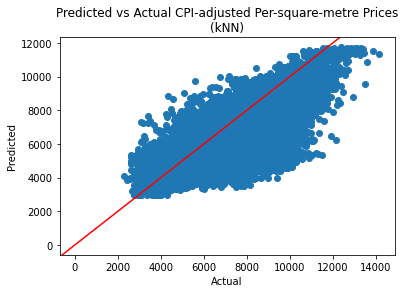

In [18]:
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(kNN)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.axline((0, 0), slope=1, color="red")
plt.show()

In [19]:

def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [20]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 708562.9645082854
RMSE: 841.7618217217299
MAE: 583.6696106083557
R2: 0.6447619116874838
MAPE: 0.10376206963823345
MdAPE: 0.08242460991003833


In [21]:
pred_df = pd.merge(pd.Series(y_test, name="y_test").reset_index(drop=True), pd.Series(y_pred, name="y_pred"), right_index=True, left_index=True)

In [22]:
pred_df.to_csv("pred_df_2.csv")

In [23]:
neg_test = y_test - y_pred
print(neg_test)
print(y_test)

767022     205.118478
767023    -110.460995
767024     -92.165712
767025     186.300277
767026      87.470389
             ...     
865822     189.687340
865823     174.715256
865824       9.307610
865825     739.280778
865826    1258.148677
Name: cpi_psm, Length: 98805, dtype: float64
767022    4425.702811
767023    6620.113788
767024    3570.737495
767025    5187.907184
767026    4871.575856
             ...     
865822    4373.831776
865823    6170.212766
865824    5705.882353
865825    5671.641791
865826    6450.336283
Name: cpi_psm, Length: 98805, dtype: float64


In [24]:
print(y_pred)

[4220.58433354 6730.57478364 3662.90320747 ... 5696.57474255 4932.36101309
 5192.18760655]
